# Toronto anomalies analysis
Anomalies detection and performance measurement

### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import utils
import os.path
from __future__ import division
from sklearn import preprocessing
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import f1_score
sns.set_style('whitegrid')
sns.set_context('talk')
import statistics

### Loading the data

In [2]:
SITE = 7881
channels = pd.read_csv('../dataset/channels.csv')
channels[channels.siteId == SITE].head()

,siteId,channelId,channelName,units,isCalculated
81478,7881,14656,V Raw Average,m/s,False
81479,7881,14033,Raw Average Velocity,m/s,False
81480,7881,11738,MP1 PDEPTH_1,mm,False
81481,7881,11745,MP1 VFINAL,m/s,False
81482,7881,19698,MP1 VInterim,m/s,False


### Assigning the channelId value to variable

In [3]:
raw = 11742
final = 11744

### Using utils to load the values from chosen channels

In [4]:
raw = utils.load_channel_data(SITE, raw).rename('raw').fillna(0)
final = utils.load_channel_data(SITE, final).rename('final').fillna(0)

### Short description of the data

In [5]:
raw.describe()

count    334081.000000
mean        220.228096
std          99.490495
min        -253.750000
25%         212.250000
50%         251.360001
75%         268.940002
max         714.309998
Name: raw, dtype: float64

In [6]:
final.describe()

count    285241.000000
mean        248.445642
std          32.769104
min         118.669998
25%         229.869995
50%         253.250000
75%         269.390015
max         622.309998
Name: final, dtype: float64

### Creating data frame on all data

In [7]:
all_data = pd.concat([raw,final],axis=1)
all_data['diff'] = np.abs(all_data['raw'] - all_data['final'])
all_data = all_data.dropna()
all_data = all_data.reset_index()

In [8]:
all_data.describe()

,raw,final,diff
count,284093.000000,284093.000000,284093.000000
mean,233.715441,248.452225,15.119353
std,64.159360,32.796490,53.732429
min,9.660000,118.669998,0.000000
25%,218.360001,229.860001,0.000000
50%,251.929993,253.259995,0.000000
75%,269.070007,269.420013,0.000000
max,714.309998,622.309998,454.829987


### Showing the general plot of all data

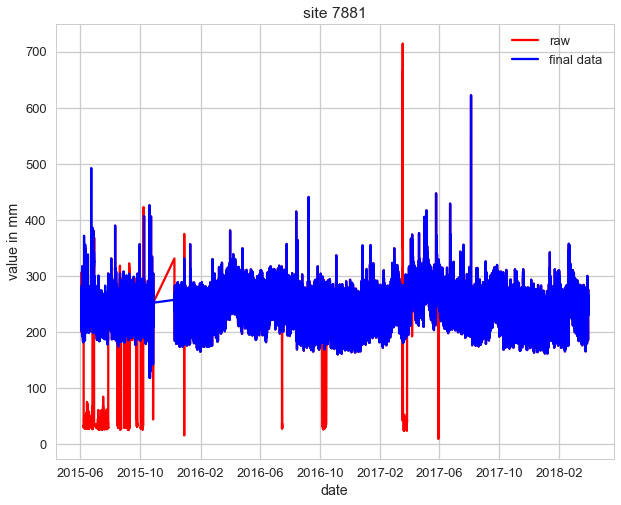

In [9]:
plt.figure(figsize=(10, 8))

plt.plot(all_data['time'].values.reshape(-1,1), all_data['raw'], color="red",
    label="raw")
plt.plot(all_data['time'].values.reshape(-1,1), all_data['final'], c='blue', label="final data")
plt.xlabel("date")
plt.ylabel("value in mm")
plt.title("site 7881")
plt.legend()
plt.show()

### Adding the difference between raw and final

In [10]:
df = pd.concat([raw, final], axis=1).dropna()
df['diff'] = np.abs(df.raw - df.final)
print('Anomalies in raw: {:}'.format(len(df[df['diff'] > 1])))

Anomalies in raw: 31150


### Creating anomalies data frame

In [11]:
anomalies = df[df['diff'] > 1]
anomalies = anomalies.reset_index()
anomalies[['raw','final','diff']].head()

,raw,final,diff
0,259.720001,275.579987,15.859985
1,253.669998,263.100006,9.430008
2,258.690002,262.519989,3.829987
3,256.290009,260.390015,4.100006
4,253.600006,259.440002,5.839996


### Short description of the anomalies data frame

In [12]:
anomalies.describe()

,raw,final,diff
count,31150.000000,31150.000000,31150.000000
mean,107.372836,241.775380,137.871722
std,103.313789,28.616929,96.994310
min,9.660000,168.910004,1.009995
25%,30.440001,221.872498,9.319996
50%,38.000000,247.149994,183.534998
75%,232.825001,259.989990,217.619995
max,714.309998,492.570007,454.829987


# Implementing and testing F1 score metric
Implementation on naive model which predicted 0 anomalies

In [13]:
print('Anomalies in raw: {:}'.format(len(all_data[all_data['diff'] > 1])))

Anomalies in raw: 31150


In [14]:
all_data['if_anomaly'] = 0
all_data['if_anomaly'] = (all_data['diff']).map(lambda x: 1 if x>1 else 0)

In [15]:
all_data['naive_model'] = 0

### Implementing F1 score manually

In [16]:
def F1(precision, recall):
    score = 2 * (precision * recall) / (precision + recall)
    return score

In [17]:
#TruePositive = Number of positives that are correctly predicted
#FalsePositive = Number of predicted positives that are incorrect

def precision(TruePositive, FalsePositive):
    prec = TruePositive/(TruePositive+FalsePositive)
    return prec

In [18]:
#TruePositive = Number of positives that are correctly predicted
#FalseNegative = Number of negatives that are incorrectly classified

def recall(TruePositive, FalseNegative):
    rec = TruePositive/(TruePositive+FalseNegative)
    return rec

### Implementing F1 score with the existing library

In [19]:
y_true = all_data['if_anomaly']
y_pred = all_data['naive_model']

In [20]:
f1_score(y_true, y_pred)

/home/alicja/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

# Implementing different models for anomalies detection

### First glance at the distribution of the data
Using Boxplot 

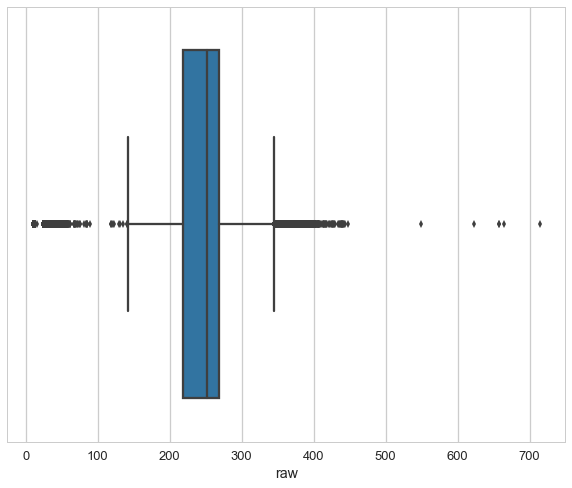

In [21]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.boxplot(x=all_data['raw'])

### Creating train and test sets

In [22]:
split_date = pd.datetime(2016,12,31,23,59)

a_training = all_data.loc[all_data['time'] <= split_date]
a_test = all_data.loc[all_data['time'] > split_date]

In [23]:
a_training.head()

,time,raw,final,diff,if_anomaly,naive_model
0,2015-06-02 10:45:00,259.720001,275.579987,15.859985,1,0
1,2015-06-02 10:50:00,253.669998,263.100006,9.430008,1,0
2,2015-06-02 10:55:00,258.690002,262.519989,3.829987,1,0
3,2015-06-02 11:00:00,256.290009,260.390015,4.100006,1,0
4,2015-06-02 11:05:00,253.600006,259.440002,5.839996,1,0


In [24]:
a_test.head()

,time,raw,final,diff,if_anomaly,naive_model
153054,2017-01-01 00:00:00,222.050003,222.050003,0.0,0,0
153055,2017-01-01 00:05:00,219.339996,219.339996,0.0,0,0
153056,2017-01-01 00:10:00,220.119995,220.119995,0.0,0,0
153057,2017-01-01 00:15:00,219.910004,219.910004,0.0,0,0
153058,2017-01-01 00:20:00,218.350006,218.350006,0.0,0,0


### Standard deviation for outliers detection (2 std from the mean)

In [25]:
x = statistics.stdev(a_training['raw'])

In [26]:
y = statistics.mean(a_training['raw'])

In [27]:
up_limit = y + (2 * x)
down_limit = y - (2 * x)

In [28]:
pd.options.mode.chained_assignment = None
a_test['std_anomaly'] = 0

In [29]:
a_test['std_anomaly'] = (a_test['raw']).map(lambda x: 1 if x> up_limit or x<down_limit else 0)

In [30]:
y_true2 = a_test['if_anomaly']
y_pred2 = a_test['std_anomaly']

In [31]:
f1_score(y_true2, y_pred2)

0.8557563587684069

# Exponentially Weighted Moving Average (EWMA)

Meaning of the colors:
Orange line - noisy data set
Blue line - backwards filtered EWMA data set
Red line - forwards filtered EWMA data set
Green line - sum and average of the two EWMA data sets

### Plotting backwards and forwards filtered EWMA

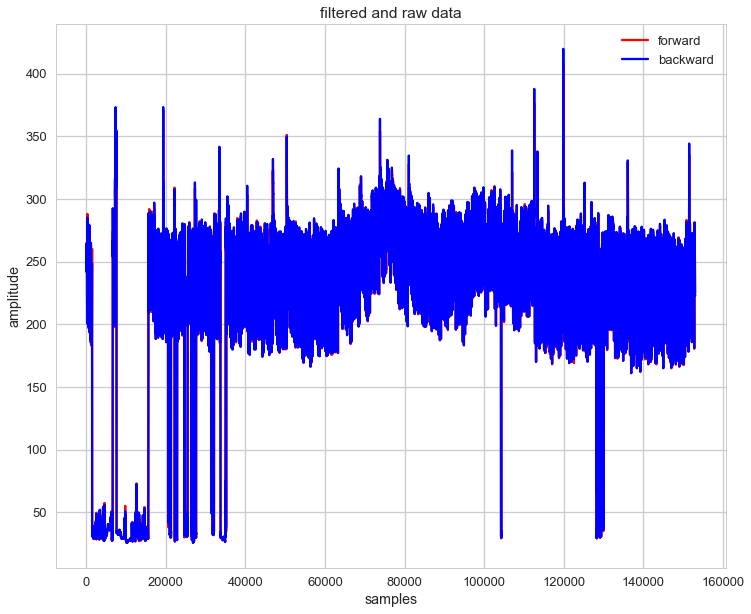

In [70]:
ewma = pd.Series.ewm
x = a_training['time']
y = a_training['raw']
df = pd.Series(y)
# take EWMA in both directions then average them
fwd = ewma(df,span=10).mean() # take EWMA in fwd direction
bwd = ewma(df[::-1],span=10).mean() # take EWMA in bwd direction
filtered = np.vstack(( fwd, bwd[::-1] )) # lump fwd and bwd together
filtered = np.mean(filtered, axis=0 ) # average
plt.figure(figsize=(12,10))
plt.title('filtered and raw data')
plt.plot(fwd, color='red', label="forward")
plt.plot(bwd, color='blue', label="backward")
plt.xlabel('samples')
plt.ylabel('amplitude')
plt.legend()
plt.show()

### Plotting noisy data and final data

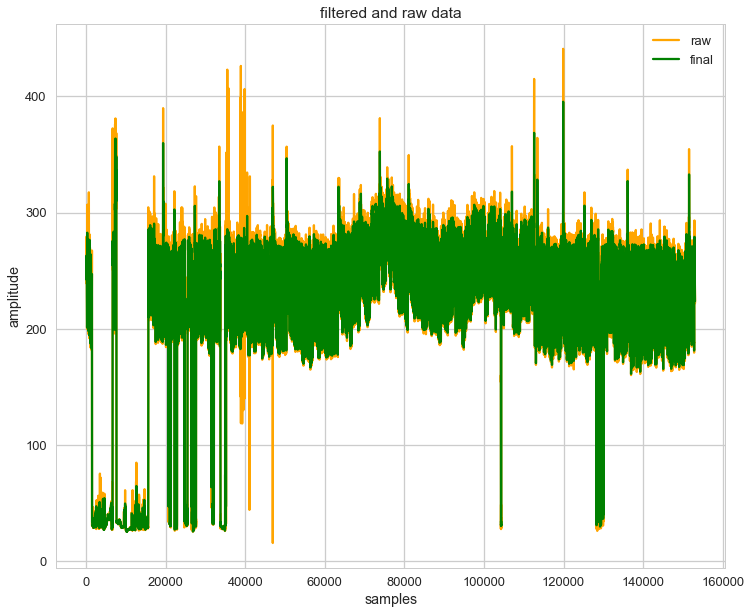

In [72]:
x = a_training['time']
y = a_training['raw']
df = pd.Series(y)
# take EWMA in both directions then average them
fwd = ewma(df,span=10).mean() # take EWMA in fwd direction
bwd = ewma(df[::-1],span=10).mean() # take EWMA in bwd direction
filtered = np.vstack(( fwd, bwd[::-1] )) # lump fwd and bwd together
filtered = np.mean(filtered, axis=0 ) # average
plt.figure(figsize=(12,10))
plt.title('filtered and raw data')
plt.plot(y, color = 'orange', label="raw")
plt.plot(filtered, color='green', label="final")
plt.xlabel('samples')
plt.ylabel('amplitude')
plt.legend()
plt.show()

In [75]:
a_training['filtered'] = filtered

In [77]:
a_training['ewma_diff'] = np.abs(a_training['raw'] - a_training['filtered'])

In [99]:
a_training['ewma'] = 0
a_training['ewma'] = (a_training['ewma_diff']).map(lambda x: 1 if x>0 else 0)

In [100]:
a_training.head()

,time,raw,final,diff,if_anomaly,naive_model,filtered,ewma_diff,ewma
0,2015-06-02 10:45:00,259.720001,275.579987,15.859985,1,0,258.146838,1.573163,1
1,2015-06-02 10:50:00,253.669998,263.100006,9.430008,1,0,256.133495,2.463497,1
2,2015-06-02 10:55:00,258.690002,262.519989,3.829987,1,0,256.840229,1.849773,1
3,2015-06-02 11:00:00,256.290009,260.390015,4.100006,1,0,256.412804,0.122795,1
4,2015-06-02 11:05:00,253.600006,259.440002,5.839996,1,0,255.878774,2.278768,1


In [101]:
y_true3 = a_training['if_anomaly']
y_pred3 = a_training['ewma']

In [102]:
f1_score(y_true3, y_pred3)

0.3107741209191444